In [1]:
%load_ext autoreload
%autoreload 2

# Имитационное моделирование

В этом ноутбуке исследуем и валидируем имитационную модель, позволяющую рассчитать вероятность идентификации и другие характеристики нашей системы.

In [2]:
from tabulate import tabulate
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [3]:
from rfidam.simulation import ModelParams, simulate, build_scenario_info
from rfidam.protocol.protocol import LinkProps, Protocol
from rfidam.protocol.symbols import DR, TagEncoding
from rfidam.scenario import parse_scenario
from rfidam.utils import bcolors, get_err, fmt_err, highlight, pluralize

In [4]:
def fmt_header(s):
    return highlight(s, bcolors.OKBLUE)

def fmt_delim(s):
    return highlight(s, bcolors.OKCYAN)

def fmt_float(x):
    return f'{x:.4f}'

In [216]:
LINK_PROPS = LinkProps(
    tari=12.5e-6,
    rtcal=30e-6,
    trcal=35e-6,
    m=TagEncoding.M2,
    dr=DR.DR_643,
    trext=False,
    q=4,
    use_tid=True,
    t_off=0.1)
PROTOCOL = Protocol(LINK_PROPS)

In [217]:
def build_params(scenario: str, ber: float, arrival_interval: float, num_tags: int, time_in_area: float):
    arrivals = np.arange(num_tags) * arrival_interval
    return ModelParams( 
        protocol=PROTOCOL, 
        arrivals=arrivals,
        time_in_area=time_in_area,
        scenario=parse_scenario(scenario),
        ber=ber
    )

In [218]:
def run_sim(params, n_iters = 5):
    journals = [simulate(params) for _ in tqdm(range(n_iters))]
    return journals

In [229]:
params = build_params("AAABxAAxABABx", ber=.015, arrival_interval=.2, num_tags=20000, time_in_area=2.42)

In [230]:
journals_1 = run_sim(params)

  0%|          | 0/5 [00:00<?, ?it/s]

In [231]:
round_infos_x3 = build_scenario_info(journals_1, len(params.scenario) * 3 )

### Build analytic results for the same data


In [232]:
from rfidam.chains import estimate_rounds_props
from rfidam.statistics import count_averages, group_round_values

rounds_props = estimate_rounds_props(params.scenario*100, params.protocol, ber=.015, arrival_interval=.2, time_in_area=2.42)
rounds_props['n_active_tags_stats'] = count_averages(
    group_round_values(
        [p @ np.arange(p.shape[0]) for p in rounds_props['n_active_tags']], 
        len(params.scenario)*3
    ))

### Visualize

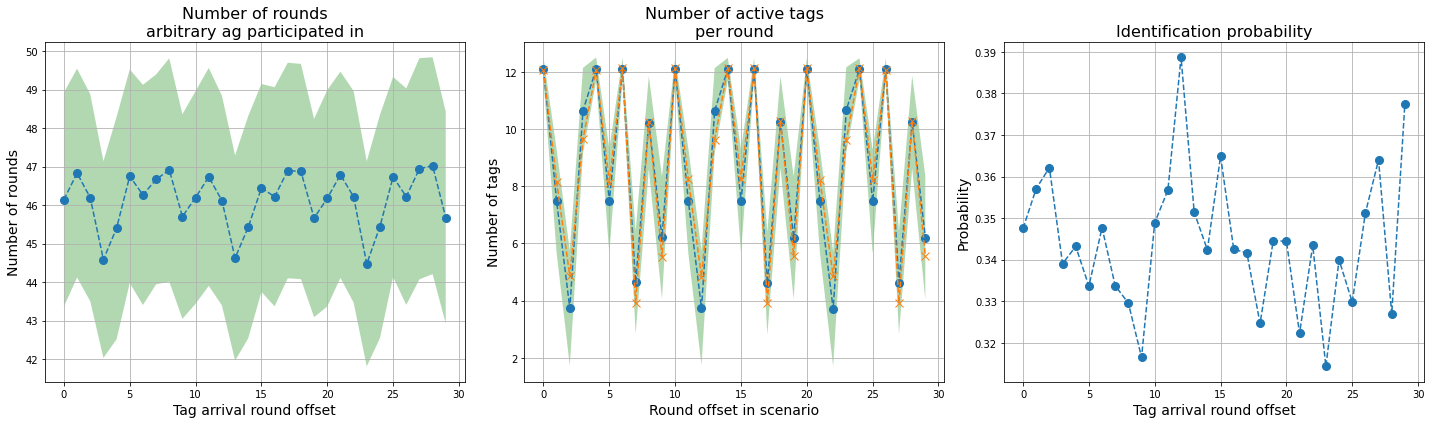

In [233]:
fig, axes = plt.subplots(figsize=(20, 6), ncols=3)
OX = np.arange(round_infos_x3.scenario_length)
axes[0].plot(OX, round_infos_x3.num_rounds_active.means, marker='o', markersize=8, linestyle='--')
axes[0].fill_between(
    OX, 
    round_infos_x3.num_rounds_active.means - round_infos_x3.num_rounds_active.errors, 
    round_infos_x3.num_rounds_active.means + round_infos_x3.num_rounds_active.errors, 
    facecolor='green', alpha=0.3)
axes[0].set_title("Number of rounds\narbitrary ag participated in", fontsize=16)
axes[0].set_xlabel('Tag arrival round offset', fontsize=14)
axes[0].set_ylabel('Number of rounds', fontsize=14)

axes[1].plot(OX, round_infos_x3.num_tags_active.means, marker='o', markersize=8, linestyle='--')
axes[1].plot(OX, rounds_props['n_active_tags_stats'].means, marker='x', markersize=8, linestyle='--')
axes[1].fill_between(
    OX, 
    round_infos_x3.num_tags_active.means - round_infos_x3.num_tags_active.errors, 
    round_infos_x3.num_tags_active.means + round_infos_x3.num_tags_active.errors, 
    facecolor='green', alpha=0.3)
axes[1].set_title("Number of active tags\nper round", fontsize=16)
axes[1].set_xlabel('Round offset in scenario', fontsize=14)
axes[1].set_ylabel('Number of tags', fontsize=14)

axes[2].plot(OX, round_infos_x3.id_probs, marker="o", markersize=8, linestyle='--')
axes[2].set_title('Identification probability', fontsize=16)
axes[2].set_xlabel('Tag arrival round offset', fontsize=14)
axes[2].set_ylabel('Probability', fontsize=14)

for ax in axes:
    ax.grid()

plt.tight_layout()

In [13]:
from collections.abc import Iterable
from itertools import product
import pandas as pd

def grid_sim(*, scenario=None, ber=None, df=None, **kwargs):
    
    def as_tuple(x):
        return x if not isinstance(x, str) and isinstance(x, Iterable) else (x,)
    
    key_defs = [
        ('tari', 125),
        ('rtcal', 300),
        ('trcal', 350),
        ('m', TagEncoding.M2),
        ('dr', DR.DR_643),
        ('trext', False),
        ('q', 2),
        ('use_tid', True),
        ('t_off', 100),
        ('arrival_interval', 170),
        ('time_in_area', 1000),
        ('max_tags', 100),
        ('n_iters', 2),
    ]
    
    key_tuples = {key: as_tuple(kwargs.get(key, default)) for key, default in key_defs}
    key_tuples.update({
        'scenario': as_tuple(scenario),
        'ber': as_tuple(ber),
    })

    df = kwargs.get('df', pd.DataFrame({
        "tari": pd.Series(dtype="uint16"),
        "rtcal": pd.Series(dtype="uint16"),
        "trcal": pd.Series(dtype="uint16"),
        "m": pd.Series(dtype="object"),
        "dr": pd.Series(dtype="object"),
        "trext": pd.Series(dtype="bool"),
        "q": pd.Series(dtype="uint8"),
        "use_tid": pd.Series(dtype="bool"),
        "t_off" # TODO: FINISH THIS
    }))
    

    # Store keys and values. Make sure order is preserved.
    all_keys = []
    all_values = []
    for key, values in key_tuples.items():
        all_keys.append(key)
        all_values.append(values)
    
    # Build grid
    grid = list(product(*all_values))
    for record in grid:
        attrs = ", ".join([f'{key}={value}' for key, value in zip(all_keys, record)])
        print(f'* simulating {attrs}')


grid_sim(
    # Protocol:
    tari=125,                 # scale: 100 ns
    rtcal=300,                # scale: 100 ns
    trcal=350,                # scale: 100ns = .1us, e.g. 350 is 35e-6~s = 35~us = 35000~ns
    m=TagEncoding.M2,
    dr=DR.DR_643,
    trext=False,
    q=2,
    use_tid=True,
    t_off=100,                 # ms
    # Specific:
    scenario='ABABx',
    ber=[1, 2, 5],              # pro mille, i.e. 5 pro mille = 0.5 % = 0.005 (Prob)
    arrival_interval=170,       # ms 
    time_in_area=[1000, 2000],  # ms
    max_tags=1000,
    n_iters=2,
)

SyntaxError: invalid syntax (<ipython-input-13-e3baba24f3c1>, line 42)